In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
from iris.util import broadcast_to_shape
import numpy.ma as ma
import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs

In [2]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [3]:
#setting file path
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'

#loading in control, july, and january runs 
july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767'] 
january = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]
control = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 


In [4]:
lat_constraint = iris.Constraint(latitude=lambda v: -35 <= v <= 35)#constraining to tropical latitudes all long

#x_wind = E-W component
#y_wind = N-S component

## JULY ## 

x_wind_cubes_july = iris.cube.CubeList()
y_wind_cubes_july = iris.cube.CubeList()

for job_id in july:

    wind_infile = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_10m_surf_wind.nc')
    x_wind_raw = wind_infile[0].extract(lat_constraint)
    y_wind_raw = wind_infile[1].extract(lat_constraint)

    x_wind_cubes_july.append(x_wind_raw)
    y_wind_cubes_july.append(y_wind_raw)
    
x_wind_cubes_jan = iris.cube.CubeList()
y_wind_cubes_jan = iris.cube.CubeList()

## JAN ##
    
for job_id in january:

    wind_infile = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_10m_surf_wind.nc')
    x_wind_raw = wind_infile[0].extract(lat_constraint)
    y_wind_raw = wind_infile[1].extract(lat_constraint)

    x_wind_cubes_jan.append(x_wind_raw)
    y_wind_cubes_jan.append(y_wind_raw)
    
## CONTROL ##
    
x_wind_cubes_cntl = iris.cube.CubeList()
y_wind_cubes_cntl = iris.cube.CubeList()
    
for job_id in control:

    wind_infile = iris.load(dir_in_coupled+'Control/'+job_id+'_10m_surf_wind.nc')
    x_wind_raw = wind_infile[0].extract(lat_constraint)
    y_wind_raw = wind_infile[1].extract(lat_constraint)

    x_wind_cubes_cntl.append(x_wind_raw)
    y_wind_cubes_cntl.append(y_wind_raw)

In [5]:
#merging cubes
x_wind_july = merge_cubes(x_wind_cubes_july)
y_wind_july = merge_cubes(y_wind_cubes_july)

x_wind_jan = merge_cubes(x_wind_cubes_jan)
y_wind_jan = merge_cubes(y_wind_cubes_jan)

x_wind_cntl = merge_cubes(x_wind_cubes_cntl)
y_wind_cntl = merge_cubes(y_wind_cubes_cntl)

In [6]:
#extracting x_wind (E-W) ensemble mean for 12 months post eruption
x_wind_july_highres = x_wind_july[0:9].collapsed('realization',iris.analysis.MEAN)
x_wind_july_highres = x_wind_july_highres[6:18].collapsed('time',iris.analysis.MEAN)#from july

x_wind_jan_highres = x_wind_jan[0:9].collapsed('realization',iris.analysis.MEAN)
x_wind_jan_highres = x_wind_jan_highres[0:12].collapsed('time',iris.analysis.MEAN)#from jan

x_wind_cntl_highres = x_wind_cntl[0:9].collapsed('realization',iris.analysis.MEAN)
x_wind_cntl_highres = x_wind_cntl_highres[0:18].collapsed('time',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [7]:
#reducing size of x and y wind components by taking every 8th data point
reduced_x_july = x_wind_july[:,:,0::8,0::8]
reduced_y_july = y_wind_july[:,:,0::8,0::8]

reduced_x_jan = x_wind_jan[:,:,0::8,0::8]
reduced_y_jan = y_wind_jan[:,:,0::8,0::8]

reduced_x_cntl = x_wind_cntl[:,:,0::8,0::8]
reduced_y_cntl = y_wind_cntl[:,:,0::8,0::8]

In [8]:
#extracting lat and long coordinates
xlon = reduced_x_july.coord('longitude')
ylon = reduced_y_july.coord('longitude')
xlat = reduced_x_july.coord('latitude')
ylat = reduced_y_july.coord('latitude')

In [9]:
#taking the average for the 12-months post-eruption
year1_x_july = reduced_x_july[:,6:18,:,:].collapsed('time',iris.analysis.MEAN)
year1_y_july = reduced_y_july[:,6:18,:,:].collapsed('time',iris.analysis.MEAN)

year1_x_jan = reduced_x_jan[:,0:12,:,:].collapsed('time',iris.analysis.MEAN)
year1_y_jan = reduced_y_jan[:,0:12,:,:].collapsed('time',iris.analysis.MEAN)

year1_x_cntl = reduced_x_cntl[:,0:18,:,:].collapsed('time',iris.analysis.MEAN)
year1_y_cntl = reduced_y_cntl[:,0:18,:,:].collapsed('time',iris.analysis.MEAN)

In [10]:
#averaging across ensembles
avg_july_x = year1_x_july.collapsed('realization',iris.analysis.MEAN)
avg_july_y = year1_y_july.collapsed('realization',iris.analysis.MEAN)

avg_jan_x = year1_x_jan.collapsed('realization',iris.analysis.MEAN)
avg_jan_y = year1_y_jan.collapsed('realization',iris.analysis.MEAN)

avg_cntl_x = year1_x_cntl.collapsed('realization',iris.analysis.MEAN)
avg_cntl_y = year1_y_cntl.collapsed('realization',iris.analysis.MEAN)

In [11]:
#defining x and y
x = xlon.points
y = xlat.points

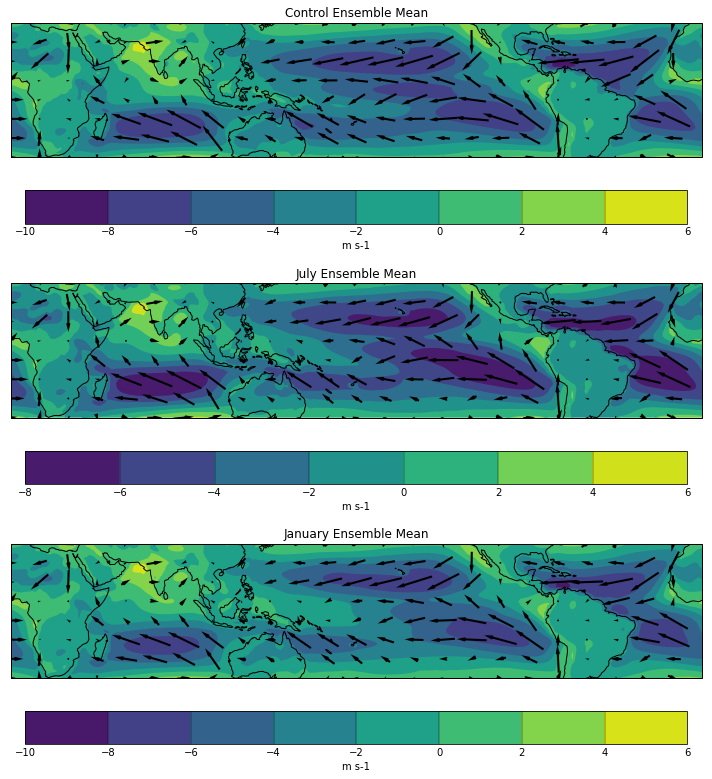

In [12]:
### Plotting Wind Dynamics ###

plt.figure(figsize=(10,11))
projection=ccrs.PlateCarree(central_longitude=180.0) #setting projection, 180 centers plot on Pacific
transform = xlon.coord_system.as_cartopy_projection()

##Control##

plt.subplot(3,1,1, projection=projection)

u = avg_cntl_x.data
v = avg_cntl_y.data

qplt.contourf(x_wind_cntl_highres) #contouring E-W wind speed
plt.gca().coastlines()
plt.title('Control Ensemble Mean')
plt.quiver(x, y, u, v, pivot='middle', transform=transform, scale_units='x', scale=0.4, headwidth = 2, headlength = 4, width = 0.003)
#plotting wind direction arrows. Size = wind speed

## JULY ##

plt.subplot(3,1,2, projection=projection)

u = avg_july_x.data
v = avg_july_y.data

qplt.contourf(x_wind_july_highres) #contouring E-W wind speed
plt.gca().coastlines()
plt.title('July Ensemble Mean')
plt.quiver(x, y, u, v, pivot='middle', transform=transform, scale_units='x', scale=0.4, headwidth = 2, headlength = 4, width = 0.003)
#plotting wind direction arrows. Size = wind speed

## JAN ##

plt.subplot(3,1,3, projection=projection)

u = avg_jan_x.data
v = avg_jan_y.data

qplt.contourf(x_wind_jan_highres) #contouring E-W wind speed
plt.gca().coastlines()
plt.title('January Ensemble Mean')
plt.quiver(x, y, u, v, pivot='middle', transform=transform, scale_units='x', scale=0.4, headwidth = 2, headlength = 4, width = 0.003)
#plotting wind direction arrows. Size = wind speed

plt.tight_layout()

plt.savefig('Wind_Comparision_Timing.pdf')